In [1]:
import ppsim as pp
from dataclasses import dataclass
import dataclasses
import numpy as np
from matplotlib import pyplot as plt
import pickle

import ipywidgets as widgets

# CRN (chemical reaction network) notation for specifying protocols



In [4]:
# CRN for approximate majority
a,b,u = pp.species('A B U')
approx_majority = [
    a+b >> 2*u,
    a+u >> 2*a,
    b+u >> 2*b,
]

 Time: 25.700


(0.0, 100000.0)

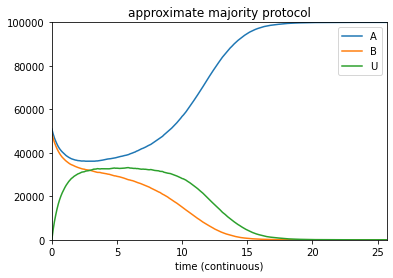

In [5]:
n = 10 ** 5
init_config = {a: 0.51*n, b: 0.49*n}
sim = pp.Simulation(init_config, approx_majority)
sim.run(history_interval=0.1)
sim.history.plot()
plt.title('approximate majority protocol')
plt.xlim(0, sim.times[-1])
plt.ylim(0, n)

# DSD oscillator 

Below is an implementation of a rock-paper-scissors (RPS) oscillator using DNA strand displacement. The "formal" CRN for the RPS oscillator is 

- A+B &rarr; 2B
- B+C &rarr; 2C
- C+A &rarr; 2A

Each reaction is implemented by 8 lower-level reactions describing DNA interactions. For details, see Fig. 1 in http://dx.doi.org/10.1126/science.aal2052 (bioRxiv verion: https://www.biorxiv.org/content/10.1101/138420v2).

In [66]:
from ppsim import species

# Fig. 1 in https://www.biorxiv.org/content/10.1101/138420v2.full.pdf
# A+B --> 2B
# B+C --> 2C
# C+A --> 2A

# signal species (represent formal species in formal CRN above)
# index indicates whether it was the first or second product of a previous reaction
b1, b2, c1, c2, a1, a2 = species('b1  b2  c1  c2  a1  a2')

signal_species = [b1, b2, c1, c2, a1, a2]

# fuel species react step
react_a_b_b1, back_a_b = species('react_a_b_b1  back_a_b')
react_b_c_c1, back_b_c = species('react_b_c_c1  back_b_c')
react_c_a_a1, back_c_a = species('react_c_a_a1  back_c_a')

react_species = [react_a_b_b1, react_b_c_c1, react_c_a_a1]
back_species = [back_a_b, back_b_c, back_c_a]

# fuel species produce step
produce_b_b1_b2, helper_b_b2 = species('produce_b_b1_b2  helper_b_b2')
produce_c_c1_c2, helper_c_c2 = species('produce_c_c1_c2  helper_c_c2')
produce_a_a1_a2, helper_a_a2 = species('produce_a_a1_a2  helper_a_a2')

produce_species = [produce_b_b1_b2, produce_c_c1_c2, produce_a_a1_a2]
helper_species = [helper_b_b2, helper_c_c2, helper_a_a2]
fuel_species = react_species + produce_species

# intermediate species
flux_b_b1, flux_c_c1, flux_a_a1 = species('flux_b_b1  flux_c_c1  flux_a_a1')
reactint_a1_b_b1, reactint_b1_c_c1, reactint_c1_a_a1 = species('reactint_a1_b_b1  reactint_b1_c_c1  reactint_c1_a_a1') 
reactint_a2_b_b1, reactint_b2_c_c1, reactint_c2_a_a1 = species('reactint_a2_b_b1  reactint_b2_c_c1  reactint_c2_a_a1') 
productint_b_b1_b2, productint_c_c1_c2, productint_a_a1_a2 = species('productint_b_b1_b2  productint_c_c1_c2  productint_a_a1_a2')

flux_species = [flux_b_b1, flux_c_c1, flux_a_a1]
reactint_species = [reactint_a1_b_b1, reactint_b1_c_c1, reactint_c1_a_a1,
                    reactint_a2_b_b1, reactint_b2_c_c1, reactint_c2_a_a1]
produceint_species = [productint_b_b1_b2, productint_c_c1_c2, productint_a_a1_a2]

# waste species react step
waste_a1_b1, waste_a1_b2, waste_a2_b1, waste_a2_b2 = species('waste_a1_b1  waste_a1_b2  waste_a2_b1  waste_a2_b2')
waste_b1_c1, waste_b1_c2, waste_b2_c1, waste_b2_c2 = species('waste_b1_c1  waste_b1_c2  waste_b2_c1  waste_b2_c2')
waste_c1_a1, waste_c1_a2, waste_c2_a1, waste_c2_a2 = species('waste_c1_a1  waste_c1_a2  waste_c2_a1  waste_c2_a2')

# waste species produce step
waste_b_b1_b2, waste_c_c1_c2, waste_a_a1_a2 = species('waste_b_b1_b2  waste_c_c1_c2  waste_a_a1_a2')

waste_species = [waste_a1_b1, waste_a1_b2, waste_a2_b1, waste_a2_b2,
                 waste_b1_c1, waste_b1_c2, waste_b2_c1, waste_b2_c2,
                 waste_c1_a1, waste_c1_a2, waste_c2_a1, waste_c2_a2,
                 waste_b_b1_b2, waste_c_c1_c2, waste_a_a1_a2]

# DSD reactions implementing formal CRN
# A+B --> 2B
ab_react_rxns = [
    a1 + react_a_b_b1 | back_a_b + reactint_a1_b_b1,
    a2 + react_a_b_b1 | back_a_b + reactint_a2_b_b1,
    reactint_a1_b_b1 + b1 >> waste_a1_b1 + flux_b_b1, # typo in Fig. 1; these rxns irreversible
    reactint_a1_b_b1 + b2 >> waste_a1_b2 + flux_b_b1, #
    reactint_a2_b_b1 + b1 >> waste_a2_b1 + flux_b_b1, #
    reactint_a2_b_b1 + b2 >> waste_a2_b2 + flux_b_b1, #
]
ab_produce_rxns = [
    flux_b_b1 + produce_b_b1_b2 | b1 + productint_b_b1_b2,
    helper_b_b2 + productint_b_b1_b2 >> waste_b_b1_b2 + b2,
]
ab_rxns = ab_react_rxns + ab_produce_rxns

# B+C --> 2C
bc_react_rxns = [
    b1 + react_b_c_c1 | back_b_c + reactint_b1_c_c1,
    b2 + react_b_c_c1 | back_b_c + reactint_b2_c_c1,
    reactint_b1_c_c1 + c1 >> waste_b1_c1 + flux_c_c1,
    reactint_b1_c_c1 + c2 >> waste_b1_c2 + flux_c_c1,
    reactint_b2_c_c1 + c1 >> waste_b2_c1 + flux_c_c1,
    reactint_b2_c_c1 + c2 >> waste_b2_c2 + flux_c_c1,
]
bc_produce_rxns = [
    flux_c_c1 + produce_c_c1_c2 | c1 + productint_c_c1_c2,
    helper_c_c2 + productint_c_c1_c2 >> waste_c_c1_c2 + c2,
]
bc_rxns = bc_react_rxns + bc_produce_rxns

# C+A --> 2A
ca_react_rxns = [
    c1 + react_c_a_a1 | back_c_a + reactint_c1_a_a1,
    c2 + react_c_a_a1 | back_c_a + reactint_c2_a_a1,
    reactint_c1_a_a1 + a1 >> waste_c1_a1 + flux_a_a1,
    reactint_c1_a_a1 + a2 >> waste_c1_a2 + flux_a_a1,
    reactint_c2_a_a1 + a1 >> waste_c2_a1 + flux_a_a1,
    reactint_c2_a_a1 + a2 >> waste_c2_a2 + flux_a_a1,
]
ca_produce_rxns = [
    flux_a_a1 + produce_a_a1_a2 | a1 + productint_a_a1_a2,
    helper_a_a2 + productint_a_a1_a2 >> waste_a_a1_a2 + a2,
]
ca_rxns = ca_react_rxns + ca_produce_rxns

all_rps_dsd_rxns = ab_rxns + bc_rxns + ca_rxns

all_species = signal_species + \
              react_species + \
              back_species + \
              produce_species + \
              helper_species + \
              flux_species + \
              reactint_species + \
              produceint_species + \
              waste_species

def state_map(state):
    if state in signal_species:
        return state.name[0]
    if state in react_species:
        return 'react'
    if state in produce_species:
        return 'produce'
    if state in waste_species:
        return 'waste'
    if state in helper_species:
        return 'helper'

In [92]:
from ppsim import Simulation, RateConstantUnits, concentration_to_count

uL = 10 ** -6  # 1 uL (microliter)
nM = 10 ** -9  # 1 nM (nanomolar)

k = 1e6  # forward rate constant in mass-action units
r = 1e6  # reverse rate constant in mass-action units
for rxn in all_rps_dsd_rxns:
    rxn.k(k, units=RateConstantUnits.mass_action)
    if rxn.reversible:
        rxn.r(r, units=RateConstantUnits.mass_action)

vol = 1 * uL

# scale time to make simulations take less time
time_scaling = 1
vol /= time_scaling

react_conc = 100 * nM
back_conc = 100 * nM
# paper had helper_conc at 75 nM, but they were dying out first
helper_conc = 100 * nM
produce_conc = 100 * nM
a1_conc = 5 * nM
b1_conc = 10 * nM
c1_conc = 5 * nM

react_count = concentration_to_count(react_conc, vol)
back_count = concentration_to_count(back_conc, vol)
helper_count = concentration_to_count(helper_conc, vol)
produce_count = concentration_to_count(produce_conc, vol)
a1_count = concentration_to_count(a1_conc, vol)
b1_count = concentration_to_count(b1_conc, vol)
c1_count = concentration_to_count(c1_conc, vol)

init_config_react = {specie: react_count for specie in react_species}
init_config_back = {specie: back_count for specie in back_species}
init_config_helper = {specie: helper_count for specie in helper_species}
init_config_produce = {specie: produce_count for specie in produce_species}

init_config = {a1: a1_count, b1: b1_count, c1: c1_count}
init_config.update(init_config_react)
init_config.update(init_config_back)
init_config.update(init_config_helper)
init_config.update(init_config_produce)

# volume_for_simulation = concentration_to_count(1, vol)
sim = Simulation(init_config=init_config, rule=all_rps_dsd_rxns, volume=vol)
# num_hours = 10
num_seconds = 1
sim.run(history_interval=0.1, run_until=num_seconds)
# df = sim.history
# spec = ['a','b','c']
# for x in spec:
#     df[x] = df[x + '1'] + df[x + '2']
# sim.history(['a1','a2','b1','b2','c1','c2']).plot()
# plt.title('DNA strand displacement implementation of RPS oscillator')
# plt.xlim(0, sim.times[-1])
# plt.ylim(0, sim.n)

 Time: 1.000


In [71]:
df[spec].plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='time (continuous)'>

In [69]:
df.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='time (continuous)'>

In [107]:
sim.config_array

array([ 2738174347,         530,  5477712691,        1082, 60493664596,
       60764562360, 60493658476,  2737547356,        1108,      639039,
           1273335,     1272170, 60221407068, 60221406492, 60221406470,
       60221385367, 60221363304, 60221363568,       21701,       43188,
             42902, 59949150604, 59678252840, 59949156724,   270939363,
                 2,   541838532,          26,   271589582,          22,
           1317631,           0,           0,           0,         532,
           1316202,           0,           0,           0,        1108,
            661272,           0,           0,           0,        1130],
      dtype=int64)

In [65]:
df.iloc[0]

a1                     301
a2                       0
b1                     602
b2                       0
back_a_b              6022
back_b_c              6022
back_c_a              6022
c1                     301
c2                       0
flux_a_a1                0
flux_b_b1                0
flux_c_c1                0
helper_a_a2           4517
helper_b_b2           4517
helper_c_c2           4517
produce_a_a1_a2       6022
produce_b_b1_b2       6022
produce_c_c1_c2       6022
productint_a_a1_a2       0
productint_b_b1_b2       0
productint_c_c1_c2       0
react_a_b_b1          6022
react_b_c_c1          6022
react_c_a_a1          6022
reactint_a1_b_b1         0
reactint_a2_b_b1         0
reactint_b1_c_c1         0
reactint_b2_c_c1         0
reactint_c1_a_a1         0
reactint_c2_a_a1         0
waste_a1_b1              0
waste_a1_b2              0
waste_a2_b1              0
waste_a2_b2              0
waste_a_a1_a2            0
waste_b1_c1              0
waste_b1_c2              0
w

In [ ]:
%matplotlib widget
sp = pp.StatePlotter(state_map)
sim.add_snapshot(sp)

In [ ]:
sp._matrix

In [ ]:
import pandas as pd
df = pd.DataFrame(data=np.matmul(sim.history.to_numpy(), sp._matrix), columns=sp.categories)
# h = sim.history.to_numpy()

In [ ]:
df.plot()

In [ ]:
sp._matrix.shape

In [ ]:
len(sim.state_list)

In [93]:
num_hours = 24
sim.run(history_interval=0.1, run_until=num_hours * 3600)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [94]:
sp._matrix

array([[1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1],
       [0,

In [104]:
import pandas as pd
df = pd.DataFrame(data=np.matmul(sim.history.to_numpy(), sp._matrix), columns=sp.categories)
# h = sim.history.to_numpy()

In [105]:
df.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:>

In [97]:
sp._matrix.shape

(45, 7)

In [84]:
len(sim.state_list)

45

In [21]:
num_hours = 24
sim.run(history_interval=0.1, run_until=num_hours * 3600)

In [62]:
sp.ax.set_yscale('linear')
sim.snapshot_slider()

interactive(children=(IntSlider(value=0, description='index', layout=Layout(width='100%'), max=600), Output())…

In [83]:
sim.history

,a1,a2,b1,b2,back_a_b,back_b_c,back_c_a,c1,c2,flux_a_a1,...,waste_b2_c2,waste_b_b1_b2,waste_c1_a1,waste_c1_a2,waste_c2_a1,waste_c2_a2,waste_c_c1_c2,a,b,c
time (continuous),,,,,,,,,,,,,,,,,,,,,
0.0,3011070380,0,6022140760,0,60221407600,60221407600,60221407600,3011070380,0,0,...,0,0,0,0,0,0,0,3011070380,6022140760,3011070380
0.1,2981264593,0,5962547947,0,60251206082,60280985634,60251212105,2981251194,0,7305,...,0,0,7325,0,0,0,0,2981264593,5962547947,2981251194
0.2,2952040010,3,5904145431,1,60280408899,60339344893,60280410858,2952009388,2,29071,...,0,1,29281,0,0,0,2,2952040013,5904145432,2952009390
0.3,2923401623,8,5846936539,7,60309012147,60396482840,60309019389,2923330387,7,64210,...,0,7,64847,0,0,0,7,2923401631,5846936546,2923330394
0.4,2895327649,12,5790894470,27,60337037946,60452428639,60337038736,2895214955,27,112385,...,0,27,113878,0,0,0,27,2895327661,5790894497,2895214982
0.5,2867804437,32,5735976116,64,60364500500,60507226026,60364492436,2867640227,72,173043,...,0,65,175976,0,0,0,73,2867804469,5735976180,2867640299
0.6,2840829679,61,5682166905,151,60391403363,60560890857,60391400623,2840588505,153,244938,...,0,152,249953,0,0,0,154,2840829740,5682167056,2840588658
0.7,2814388661,121,5629445325,259,60417761894,60613447138,60417760829,2814061871,274,327425,...,0,261,335382,0,0,0,277,2814388782,5629445584,2814062145
0.8,2788474271,233,5577821674,438,60443582924,60664884325,60443569993,2788066184,452,420787,...,0,443,432567,0,0,0,459,2788474504,5577822112,2788066636
